In [1]:
import numpy as np
from nltk.tokenize import RegexpTokenizer
from keras.models import Sequential, load_model
from keras.layers import LSTM
from keras.layers.core import Dense, Activation
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
import heapq

In [3]:
path = '1260-0.txt'

In [4]:
text = open(path,encoding='utf8').read().lower()
print('corpus length:', len(text))

corpus length: 1041760


### We want to split the entire dataset into each word in order without the presence of special characters.

In [5]:
tokenizer = RegexpTokenizer(r'\w+')
words = tokenizer.tokenize(text)

### For the feature engineering part, we need to have the unique sorted words list. We also need a dictionary(<key: value>) with each word form the unique_words list as key and its corresponding position as value. Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. Feature engineering is fundamental to the application of machine learning and is both difficult and expensive.

In [6]:
unique_words = np.unique(words)
unique_word_index = dict((c, i) for i, c in enumerate(unique_words))

### We define a WORD_LENGTH which means that the number of previous words that determines the next word. Also, we create an empty list called prev_words to store a set of four previous words and its corresponding next word in the next_words list. We fill these lists by looping over a range of 4 less than the length of words.

In [7]:
WORD_LENGTH = 5
prev_words = []
next_words = []
for i in range(len(words) - WORD_LENGTH):
    prev_words.append(words[i:i + WORD_LENGTH])
    next_words.append(words[i + WORD_LENGTH])
print(prev_words[0])
print(next_words[0])

['the', 'project', 'gutenberg', 'ebook', 'of']
jane


### For generating feature vector we use one-hot encoding. Here, we create two numpy array X(for storing the features) and Y(for storing the corresponding label(here, next word)). We iterate X and Y if the word is present then the corresponding position is made 1.

In [8]:
X = np.zeros((len(prev_words), WORD_LENGTH, len(unique_words)), dtype=bool)
Y = np.zeros((len(next_words), len(unique_words)), dtype=bool)
for i, each_words in enumerate(prev_words):
    for j, each_word in enumerate(each_words):
        X[i, j, unique_word_index[each_word]] = 1
    Y[i, unique_word_index[next_words[i]]] = 1

In [9]:
print(X[0][0]) #Printing a single sequence

[False False False ... False False False]


### Building the model
#### We use a single-layer LSTM model with 128 neurons, a fully connected layer, and a softmax function for activation.

In [10]:
model = Sequential()
model.add(LSTM(130, input_shape=(WORD_LENGTH, len(unique_words))))
model.add(Dense(len(unique_words)))
model.add(Activation('softmax'))

### Training
#### The model will be trained with 20 epochs with an RMSprop optimizer.

In [11]:
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, Y, validation_split=0.05, batch_size=128, epochs=2, shuffle=True).history

C:\Users\Oishi\anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/2
1430/1430 [==============================] - 305s 212ms/step - loss: 6.3663 - accuracy: 0.1007 - val_loss: 7.1300 - val_accuracy: 0.1068
Epoch 2/2
1430/1430 [==============================] - 299s 209ms/step - loss: 6.5099 - accuracy: 0.1283 - val_loss: 7.5990 - val_accuracy: 0.1050


### After successful training, we will save the trained model and just load it back as needed.

In [12]:
model.save('keras_next_word_model.h5')
pickle.dump(history, open("history.p", "wb"))
model = load_model('keras_next_word_model.h5')
history = pickle.load(open("history.p", "rb"))

In [18]:
def prepare_input(text):
    x = np.zeros((1, WORD_LENGTH, len(unique_words)))
    for t, word in enumerate(text.split()):
        print(word)
        x[0, t, unique_word_index[word]] = 1
    return x
prepare_input("It is not a lack".lower())

it
is
not
a
lack


array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

### To choose the best possible n words after the prediction from the model is done by sample function.

In [19]:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)

    return heapq.nlargest(top_n, range(len(preds)), preds.take)

### Finally, for prediction, we use the function predict_completions which use the model to predict and return the list of n predicted words.

In [20]:
def predict_completions(text, n=3):
    if text == "":
        return("0")
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [unique_words[idx] for idx in next_indices]

In [21]:
q =  "Your life will never be the same again"
print("correct sentence: ",q)
seq = " ".join(tokenizer.tokenize(q.lower())[0:5])
print("Sequence: ",seq)
print("next possible words: ", predict_completions(seq, 5))

correct sentence:  Your life will never be the same again
Sequence:  your life will never be
your
life
will
never
be
next possible words:  ['your', 'a', 'well', 'to', 'of']


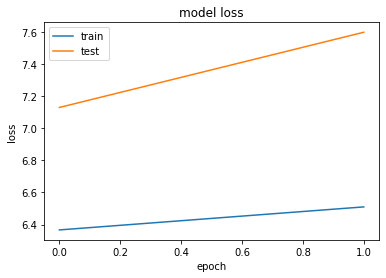

In [22]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')